# 1. Thông tin nhóm
- Huỳnh Thị Hương Ly	18133029
- Huỳnh Thiên Long	18133025
- Trần Gia Nguyên	18133036
- Phan Thành Trung	18133059

# 2. Giới thiệu sơ lược về project
- Tên đề tài: nhận biết tin giả
- Mô tả bài toán: 
Sự lan truyền thông tin sai lệch là một vấn đề ngày càng gia tăng. Việc phân loại tin tức theo cách thủ công thì tốn thời gian. Bài toán phân loại hi vọng có thể giúp phân biệt đâu là tin tức đáng tin hay tin giả.

# 3. Giải quyết bài toán

## Định dạng Spark

In [1]:
import findspark
findspark.init()

import pyspark
findspark.find()

from pyspark.sql.functions import count
from pyspark.sql.types import StringType, StructField, StructType

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

import pandas as pd
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## Read and load Fake News data set

In [2]:
def read_data(path):
  schema= StructType(
      [StructField('title',StringType(),True),
      StructField('text',StringType(),True),
      StructField('subject',StringType(),True),
      StructField('date',StringType(),True)])
  pd_df= pd.read_csv(path)
  sp_df= spark.createDataFrame(pd_df, schema= schema)
  return sp_df

In [3]:
true_df = read_data('True.csv')
fake_df = read_data('Fake.csv')

In [4]:
true_df.show(3)

+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
+--------------------+--------------------+------------+------------------+
only showing top 3 rows



In [5]:
fake_df.show(3)

+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
+--------------------+--------------------+-------+-----------------+
only showing top 3 rows



In [4]:
trueDF, truez = true_df.randomSplit([0.06, 0.94])
fakeDF, fakez = fake_df.randomSplit([0.06, 0.94])

In [5]:
from pyspark.sql.functions import lit, rand
data = trueDF.withColumn('label', lit(1)).union(fakeDF.withColumn('label', lit(0))).orderBy(rand())

In [8]:
# Tập dữ liệu gốc
data.show(5)

+--------------------+--------------------+------------+------------------+-----+
|               title|                text|     subject|              date|label|
+--------------------+--------------------+------------+------------------+-----+
|Only one-in-four ...|TORONTO (Reuters)...|politicsNews|    June 27, 2016 |    1|
|Kremlin says Puti...|MOSCOW (Reuters) ...|politicsNews|February 13, 2017 |    1|
|TRUMP WINS! Supre...|This is gonna be ...|   left-news|      Jun 26, 2017|    0|
|GITMO PRISONER OB...|Another Gitmo det...|   left-news|      Dec 10, 2015|    0|
|Trump uses policy...|GETTSYBURG, Pa. (...|politicsNews| October 22, 2016 |    1|
+--------------------+--------------------+------------+------------------+-----+
only showing top 5 rows



## Tập dữ liệu Fake News 


+ `title `                    : tên bài báo
+ `text  `                    : nội dung bài báo
+ `subject `                  : loại bài báo
+ `date `                     : ngày xuất bản
+ `label`                     : thật hay giả


In [6]:
# Xử lý giá trị null
data = data.na.fill(0)

## Check the data set

In [7]:
# Đếm số lượng tin thật/giả
data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 1301|
|    0| 1408|
+-----+-----+



In [11]:
# Kiểm tra các giá trị của cột subject
data.select('subject').distinct().show()

+---------------+
|        subject|
+---------------+
|        US_News|
|      left-news|
|      worldnews|
|       politics|
|   politicsNews|
|Government News|
|    Middle-east|
|           News|
+---------------+



## Chia tập train test thành 7/3

In [8]:
# do tập dữ liệu đã được xếp theo thứ tự nên cần xáo trộn trước khi chia tập dl
#data_df = ak.sample(fraction=0.6)
train, test = data.randomSplit([0.7, 0.3])

In [9]:
# Đếm số lượng tin thật - giả trong tập dữ liệu dùng để huấn luyện mô hình
train.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  922|
|    0|  988|
+-----+-----+



In [10]:
# Đếm số lượng tin thật - giả trong tập dữ liệu dùng để huấn luyện mô hình
test.groupBy("label").count().show() 

+-----+-----+
|label|count|
+-----+-----+
|    1|  379|
|    0|  420|
+-----+-----+



## Tạo object để xử lí dữ liệu

In [11]:
# ngyen
# Create objects for processing data
from pyspark.ml.feature import SQLTransformer, RegexTokenizer, StopWordsRemover, CountVectorizer, Imputer, IDF
from pyspark.ml.feature import StringIndexer, VectorAssembler
StopWordsRemover.loadDefaultStopWords('english')

#### thuộc tính "tittle"
# 0. Extract tokens from title
title_tokenizer= RegexTokenizer(inputCol= 'title', outputCol= 'title_words', pattern= '\\W', toLowercase= True)
# 1. Remove stop words from title
title_remove_stopwords = StopWordsRemover(inputCol= 'title_words', outputCol= 'title_remove_stopwords')
# 2. Compute Term frequency from title
title_count_vectorizer = CountVectorizer(inputCol= 'title_remove_stopwords', outputCol= 'tf_title')
# 3. Compute Term frequency-inverse document frequency from title
title_tfidf= IDF(inputCol= 'tf_title', outputCol= 'tf_idf_title')


#### thuộc tính "text"
# 4. Extract tokens from text
text_tokenizer= RegexTokenizer(inputCol= 'text', outputCol= 'text_words', pattern= '\\W', toLowercase= True)
# 5. Remove stop words from text
text_remove_stopwords = StopWordsRemover(inputCol= 'text_words', outputCol= 'text_remove_stopwords')
# 6. Compute Term frequency from text
text_count_vectorizer = CountVectorizer(inputCol= 'text_remove_stopwords', outputCol= 'tf_text')
# 7. Compute Term frequency-inverse document frequency text
text_tfidf = IDF(inputCol= 'tf_text', outputCol= 'tf_idf_text')

# 8. StringIndexer subject
subject_indexer = StringIndexer(inputCol= 'subject', outputCol= 'subject_idx')
label_indexer= StringIndexer(inputCol= 'label', outputCol= 'label_idx')
# 9. VectorAssembler
vec_assembler = VectorAssembler(inputCols=['tf_idf_title', 'tf_idf_text', 'subject_idx'], outputCol= 'features')

**Token : chuyển đổi text thành danh sách các từ**

**Term frequency (tần suất xuất hiện của từ):**
* là số lần từ xuất hiện trong văn bản
* một thuật ngữ xuất hiện càng nhiều , thường xuyên thì thuật ngữ đó càng có khả năng mang lại thông tin hữu ích cho văn bản(trừ stop-word)


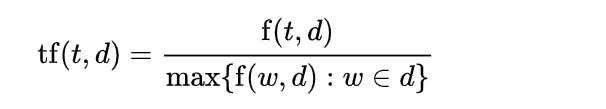
* tf(t, d): tần suất xuất hiện của từ t trong văn bản d
* f(t, d): Số lần xuất hiện của từ t trong văn bản d
* max({f(w, d) : w ∈ d}): Số lần xuất hiện của từ có số lần xuất hiện nhiều nhất trong văn bản d

**Inverse document frequency (nghịch đảo tần suất của văn bản):** 
* giúp đánh giá tầm quan trọng của 1 từ
* nếu một thuật ngữ xuất hiện hầu hết trong văn bản nó sẽ có rất ít khả năg hữu ích để phân biệt và phân loại chúng

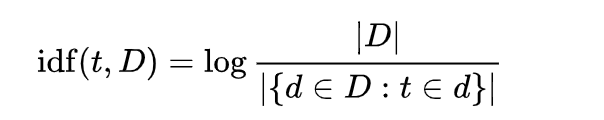
 * idf(t, D): giá trị idf của từ t trong tập văn bản
 * |D|: Tổng số văn bản trong tập D
 * |{d ∈ D : t ∈ d}|: thể hiện số văn bản trong tập D có chứa từ t.

## Tạo pipeline

In [12]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[title_tokenizer, 
                title_remove_stopwords, 
                title_count_vectorizer, 
                title_tfidf, 
                text_tokenizer, 
                text_remove_stopwords, 
                text_count_vectorizer, 
                text_tfidf, 
                subject_indexer, 
                label_indexer, 
                vec_assembler]) 
model = pipeline.fit(train)

## Biến đổi train data theo định dạng của Spark

In [13]:
final_train = model.transform(train)
final_train.select("features","label_idx").show(5)

+--------------------+---------+
|            features|label_idx|
+--------------------+---------+
|(36037,[3,34,43,2...|      1.0|
|(36037,[2,14,34,1...|      1.0|
|(36037,[0,36,43,5...|      1.0|
|(36037,[2,14,24,7...|      1.0|
|(36037,[0,3,225,4...|      1.0|
+--------------------+---------+
only showing top 5 rows



In [14]:
final_test = model.transform(test)
final_test.select("features","label_idx").show(5)

+--------------------+---------+
|            features|label_idx|
+--------------------+---------+
|(36037,[15,16,61,...|      1.0|
|(36037,[0,18,140,...|      1.0|
|(36037,[0,40,69,4...|      1.0|
|(36037,[8,140,171...|      1.0|
|(36037,[0,1107,16...|      1.0|
+--------------------+---------+
only showing top 5 rows



## Hàm đánh giá kết quả của mô hình

In [15]:
# ngyen
# Hàm để đánh giá mô hình phân loại
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator

accuracy= MulticlassClassificationEvaluator(labelCol= 'label_idx', predictionCol='prediction', metricName= 'accuracy')
f1= MulticlassClassificationEvaluator(labelCol= 'label_idx', predictionCol= 'prediction', metricName= 'f1')
areaUnderROC= BinaryClassificationEvaluator(labelCol= 'label_idx', metricName= 'areaUnderROC')

def classification_evaluator(data_result):
    data_result.crosstab(col1= 'prediction', col2= 'label_idx').show()
    print('accuracy:' ,accuracy.evaluate(data_result))
    print('f1:' ,f1.evaluate(data_result))
    print('areaUnderROC:' ,areaUnderROC.evaluate(data_result))

## NAIVE BAYES - Nguyên


### Điều chỉnh các siêu tham số của các mô hình để chọn mô hình tốt nhất bằng cách sử dụng cross validation. 

In [ ]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes().setLabelCol("label_idx").setFeaturesCol("features")

# Evaluate model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_idx", predictionCol="prediction", metricName="f1")

# Create ParamGrid for Cross Validation
nbparamGrid = (ParamGridBuilder()
               .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
               .build())

# Create 10-fold CrossValidator
nbcv = CrossValidator(estimator = nb,
                      estimatorParamMaps = nbparamGrid,
                      evaluator = evaluator,
                      numFolds = 10)

# Run cross validations.
nbcvModel = nbcv.fit(final_train)
print(nbcvModel)

### Dự đoán trên tập test và đánh giá kết quả của mô hình NaiveBayes-chọn từ crossvalidation

In [21]:
# Use test set here so we can measure the accuracy of our model on new data
nbpredictions = nbcvModel.transform(final_test)
nbpredictions.select("features","label_idx","prediction").show(5)

+--------------------+---------+----------+
|            features|label_idx|prediction|
+--------------------+---------+----------+
|(32712,[2,12,148,...|      1.0|       1.0|
|(32712,[12,17,120...|      1.0|       1.0|
|(32712,[18,43,75,...|      1.0|       1.0|
|(32712,[0,323,350...|      1.0|       1.0|
|(32712,[0,2,12,17...|      1.0|       1.0|
+--------------------+---------+----------+
only showing top 5 rows



In [22]:
# Evaluate the model
classification_evaluator(nbpredictions)

+--------------------+---+---+
|prediction_label_idx|0.0|1.0|
+--------------------+---+---+
|                 1.0| 71|702|
|                 0.0|762| 57|
+--------------------+---+---+

accuracy: 0.9195979899497487
f1: 0.9196246755750697
areaUnderROC: 0.5253294993886882


### Kết luận sau khi tinh chỉnh
Sau quá trình tinh chỉnh siêu tham số cho mô hình được huấn luyện bằng thuật toán Naive Bayes: mô hình tốt nhất có độ chính xác đạt 0.9354066985645934. Nhìn vào ma trận đánh giá, có thể thấy tin dự đoán sai khá ít nhưng vẫn chưa tốt lắm so với mong muốn ban đầu.

## RANDOMFOREST - Phan Thành Trung

### Điều chỉnh các siêu tham số của các mô hình để chọn mô hình tốt nhất bằng cách sử dụng cross validation.

In [23]:
from pyspark.ml.classification import RandomForestClassifier 
rf = RandomForestClassifier(featuresCol= 'features', labelCol= 'label_idx')

# Evaluate model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_idx", predictionCol="prediction", metricName="f1")

# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 5, 10])
             .addGrid(rf.maxBins, [10, 20])
             .addGrid(rf.numTrees, [5, 20, 50])
             .build())

# Create 10-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluator,
                      numFolds = 10)

# Run cross validations.
rfcvModel = rfcv.fit(final_train)
print(rfcvModel)

CrossValidatorModel_f3dea0a3adc2


### Dự đoán trên tập test và đánh giá kết quả của mô hình RandomForest-chọn từ crossvalidation

In [24]:
# Dự đoán
rfpredictions = rfcvModel.transform(final_test)
rfpredictions.select("features","label_idx","prediction").show(5)

+--------------------+---------+----------+
|            features|label_idx|prediction|
+--------------------+---------+----------+
|(32712,[2,12,148,...|      1.0|       1.0|
|(32712,[12,17,120...|      1.0|       1.0|
|(32712,[18,43,75,...|      1.0|       1.0|
|(32712,[0,323,350...|      1.0|       1.0|
|(32712,[0,2,12,17...|      1.0|       1.0|
+--------------------+---------+----------+
only showing top 5 rows



In [25]:
# Evaluate the model
classification_evaluator(rfpredictions)

+--------------------+---+---+
|prediction_label_idx|0.0|1.0|
+--------------------+---+---+
|                 1.0|  9|754|
|                 0.0|824|  5|
+--------------------+---+---+

accuracy: 0.9912060301507538
f1: 0.991207003564179
areaUnderROC: 0.9988438062972225


### Kết luận sau khi tinh chỉnh

Trong quá trình tinh chỉnh siêu tham số cho mô hình được huấn luyện bằng thuật toán RandomForest, thuật toán thứ nhất là thuật toán cho kết quả dự đoán tốt nhất. Mô hình tốt nhất có siêu tham số gồm 1 thuộc tính: text.

## GRADIENT BOOST - Huỳnh Thị Hương Ly

### Điều chỉnh các siêu tham số của các mô hình để chọn mô hình tốt nhất bằng cách sử dụng cross validation

In [ ]:
# Tạo Object cho mô hình
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(labelCol="label_idx", featuresCol="features")

# Evaluate model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_idx", predictionCol="prediction", metricName="f1")

# Create ParamGrid for Cross Validation
gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2, 5])
             .addGrid(gb.maxBins, [10, 20])
             .addGrid(gb.maxIter, [5, 10])
             .build())

# Create 5-fold CrossValidator
gbcv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = evaluator,
                      numFolds = 10)  

# Run cross validations.
gbcvModel = gbcv.fit(final_train)
print(gbcvModel)

### Dự đoán trên tập test và đánh giá kết quả của mô hình GradientBoost-chọn từ crossvalidation

In [ ]:
# Dự đoán 
gbpredictions = gbcvModel.transform(final_test)
gbpredictions.select("features","label_idx","prediction").show(5)

# Evaluate best model
classification_evaluator(gbpredictions)

## DECISION TREE - Huỳnh Thiên Long

### Điều chỉnh các siêu tham số của các mô hình để chọn mô hình tốt nhất bằng cách sử dụng cross validation

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier 
dt = DecisionTreeClassifier(featuresCol= 'features', labelCol= 'label_idx')

# Evaluate model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_idx", predictionCol="prediction", metricName="f1")

# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10])
             .addGrid(dt.maxBins, [10, 20])
             .build())

# Create 10-fold CrossValidator
dtcv = CrossValidator(estimator = dt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = evaluator,
                      numFolds = 10)

# Run cross validations.
dtcvModel = dtcv.fit(final_train)
print(dtcvModel)

### Dự đoán trên tập test và đánh giá kết quả của mô hình

In [ ]:
# Dự đoán 
dtpredictions = dtcvModel.transform(final_test)
dtpredictions.select("features","label_idx","prediction").show(5)

# Evaluate best model
classification_evaluator(dtpredictions)

### Kết luận sau khi tinh chỉnh

Trong quá trình tinh chỉnh siêu tham số, 3 mô hình đều cho kết quả dự đoán rất tốt. Mô hình tốt nhất là mô hình thứ 3, siêu tham số có 3 thuộc tính tittle, text và subject.

# 4. Tổng kết
Chỉ số AUR càng cao thì mô hình càng chính xác trong việc phân loại các lớp. RMSE càng nhỏ tức là sai số càng bé thì mức độ ước lượng cho thấy độ tin cậy của mô hình có thể đạt cao nhất. Độ đo bài toán đặt ra ban đầu là False Negative vì muốn so sánh thuật toán nào nhận biết tin giả thành tin thật ít nhất.

Bài toán này là bài toán phân biệt tin giả. Tùy vào trường hợp, mục đích mà có độ đo khác nhau. Mục tiêu nhóm em nhắm đến là đưa số tin giả bị nhầm thành tin thật xuống mức thấp nhất, nên độ đo nhóm chọn là False Negative. Bởi nếu vô tình nhầm tin giả thành tin thật, tin giả đó có thể gây ảnh hưởng xấu đến chúng ta. Vì thế nhóm ưu tiên chọn mô hình nhận biết nhầm tin giả thành tin thật thấp nhất.

Các chỉ số đánh giá mô hình tốt nhất của các thuật toán:
- Naive Bayes: 
 + accuracy: 0.9354066985645934
 + f1: 0.9353469577919543
 + areaUnderROC: 0.5155146785581569
 
- RandomForest:
 + accuracy: 0.9904306220095693
 + f1: 0.9904248365467685
 + areaUnderROC: 0.9994425863991081
 
- Gradient Boost:
 + accuracy: 1.0
 + f1: 1.0
 + areaUnderROC: 1.0
 
- Decision Tree:
 + accuracy: 1.0
 + f1: 1.0
 + areaUnderROC: 1.0
 
Trong 3 thuật toán, kết quả dự đoán của Gradient Boost và Decision Tree tốt nhất. Random Forest cũng khá tốt, nhưng dùng trên tập dữ liệu lớn lại quá tốn thời gian. Naive Bayse ban đầu được dự đoán là thuật toán phù hợp nhất với bài toán này, nhưng từ kết quả, có thể thấy kết quả dự đoán Naive Bayes là không bằng 3 thuật toán còn lại. Bù lại, Naive Bayes nhanh hơn Random Forrest, Gradient Boost và Decision Tree.

### So sánh accuracy của các mô hình tìm được

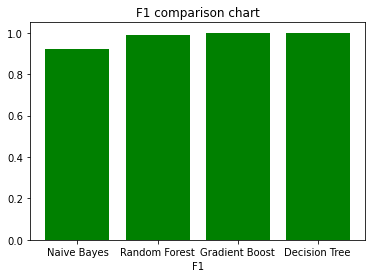

In [1]:
import matplotlib.pyplot as plt
import numpy as np

label = ["Naive Bayes", "Random Forest", "Gradient Boost", "Decision Tree"]
accuracy = [0.9196246755750697, 0.991207003564179, 1, 1]
plt.bar(label, accuracy, color='green')
plt.title("F1 comparison chart")
plt.xlabel("F1")
plt.show()